In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import pathlib

In [3]:
train_data_directory      = pathlib.Path(r"D:\ActionRecognition\Train")
validation_data_directory = pathlib.Path(r"D:\ActionRecognition\Test")

In [4]:
image_count = len(list(train_data_directory.glob('*/*.jpg')))
image_count

287

In [5]:
test_image_count = len(list(validation_data_directory.glob('*/*.jpg')))
test_image_count

117

In [7]:
CLASS_NAMES = np.array([item.name for item in train_data_directory.glob('*')])
CLASS_NAMES

array(['ApplyEyeMakeup', 'ApplyLipstick', 'Archery'], dtype='<U14')

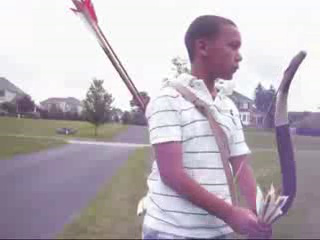

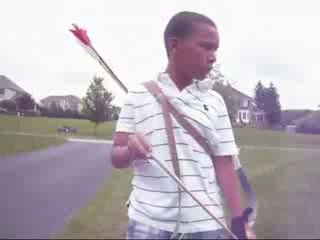

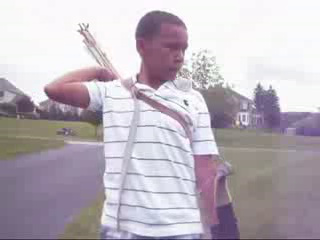

In [8]:
archery = list(train_data_directory.glob('Archery/*'))

for image_path in archery[:3]:
    display.display(Image.open(str(image_path)))

In [9]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [39]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_data_directory),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 287 images belonging to 3 classes.
None


In [13]:
validation_data_gen = image_generator.flow_from_directory(directory=str(validation_data_directory),
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                          classes = list(CLASS_NAMES))

Found 117 images belonging to 3 classes.


In [14]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

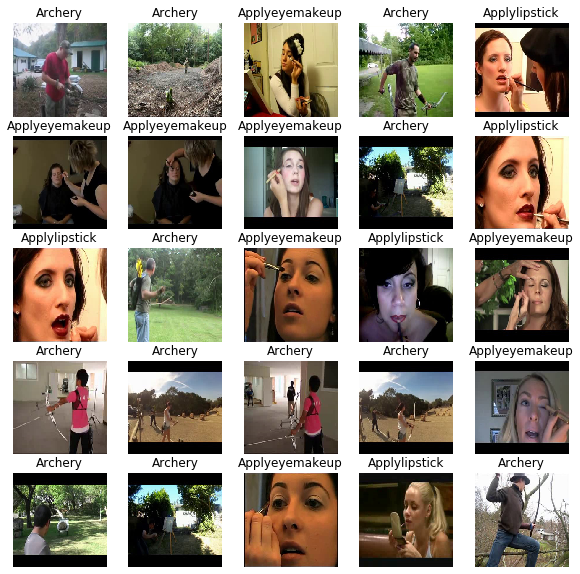

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [16]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [22]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [23]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
len(model.trainable_variables)

2

In [28]:
loss0,accuracy0 = model.evaluate(validation_data_gen)

  ...
    to  
  ['...']
4/4 [==============================] - 3s 796ms/step - loss: 1.0137 - accuracy: 0.4530


In [29]:
epochs = 3
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=validation_data_gen
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 4 steps
Epoch 1/3
9/9 [==============================] - 29s 3s/step - loss: 1.1038 - accuracy: 0.3902 - val_loss: 0.9628 - val_accuracy: 0.5128
Epoch 2/3
9/9 [==============================] - 24s 3s/step - loss: 1.0536 - accuracy: 0.4425 - val_loss: 0.9225 - val_accuracy: 0.5128
Epoch 3/3
9/9 [==============================] - 27s 3s/step - loss: 1.0098 - accuracy: 0.4983 - val_loss: 0.8692 - val_accuracy: 0.5812


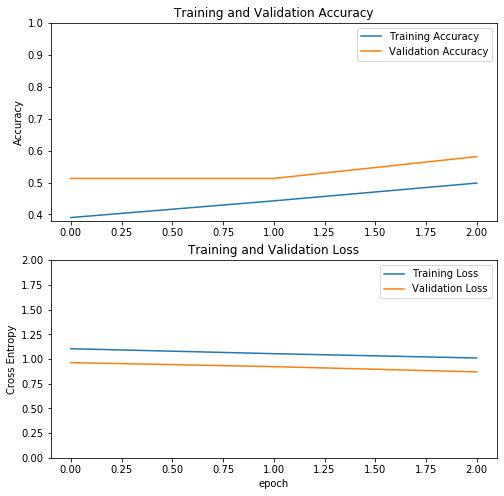

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0
